### Находим участки с __торможением__, __ускорением__ и __равномерной ездой__:

#### 1. Сначала импортируем модуль
```python
from src.utils import TSTrendEstimator
```
#### 2. Создаем датафрейм где указываем время, идентификатор авто и скорость
#### 3. Передаем эту таблицу в *TSTrendEstimator*
```python
result = TSTrendEstimator().fit_predict(df)
```
#### 4. Получаем *result*, где 
+ *X* это оригинальная скорость
+ *estimation* это оценка изменения скорости
+ *status*:
    + 1 это __ускорение__
    + 0 это __равномерная езда__
    + -1 это __торможение__

# 1. IMPORT 

In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import src
from src.utils import TSTrendEstimator, plot_TSTrendEstimation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

plt.rcParams["figure.figsize"] = (15,5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 2. LOAD DATA

In [4]:
PATH = '/home/jovyan/remote_shared_data/dsdiag222/temporary/from_ntc_batching/2020_04_26_2020_06_30_valid_distance_upd.csv'

# PATH = '/home/jovyan/remote_shared_data/dsdiag222/clipboard/2020_07_27_poligon_truck_vega_data.csv'
USECOLS = ['time', 'speed', 'car_vin']

In [5]:
%%time

df = pd.read_csv(PATH, usecols=USECOLS)
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

CPU times: user 20.7 s, sys: 1.74 s, total: 22.5 s
Wall time: 54.7 s


In [6]:
df

,speed,car_vin
time,,
2020-04-26 00:00:05,68,XTC549015K2525716
2020-04-26 00:00:07,69,XTC549015K2525716
2020-04-26 00:00:10,72,XTC549015K2525716
2020-04-26 00:00:12,74,XTC549015K2525716
2020-04-26 00:00:15,75,XTC549015K2525716
...,...,...
2020-07-01 19:58:15,7,XTC549015K2520922
2020-07-01 19:58:16,0,XTC549015K2521943
2020-07-01 19:58:17,4,XTC549015K2520922


### RESAMPLING

In [7]:
RESAMPLE_FREQ = '10s'

In [8]:
%%time

df_resampled = df.groupby('car_vin')['speed'].resample(RESAMPLE_FREQ).mean()
df_resampled.replace(0, np.nan, inplace=True)

CPU times: user 6.11 s, sys: 830 ms, total: 6.94 s
Wall time: 6.94 s


In [9]:
# Input data example
df_resampled.dropna().head(20).to_frame()

speed
car_vin           time                      
XTC549015J2510673 2020-04-26 05:25:20   1.75
                  2020-04-26 05:26:50   1.00
                  2020-04-26 05:27:00   0.25
                  2020-04-26 05:28:30   0.75
                  2020-04-26 05:29:00   0.50
                  2020-04-26 05:29:10   0.25
                  2020-04-26 05:30:00   0.25
                  2020-04-26 05:30:30   0.25
                  2020-04-26 05:31:10   0.25
                  2020-04-26 05:32:00   0.25
                  2020-04-26 05:32:50   2.25
                  2020-04-26 05:33:20   0.25
                  2020-04-26 05:33:30   1.00
                  2020-04-26 06:30:00   0.25
                  2020-04-26 06:30:20   3.75
                  2020-04-26 06:30:30   7.75
                  2020-04-26 06:30:40   8.50
                  2020-04-26 06:30:50   9.75
                  2020-04-26 06:31:00   8.75
                  2020-04-26 06:31:10   9.50

# 3. TREND ESTIMATION

In [10]:
%time res = TSTrendEstimator(alpha=10, min_coef=-1, max_coef=1).fit_predict(df_resampled)

KeyboardInterrupt: 

In [11]:
# # Or for single car
# %time TSTrendEstimator().fit_predict(df_resampled.loc['XTC549015J2510673']).dropna()

In [13]:
res['score_roll'] = res['score'].rolling(2).mean()
rand_vin = np.random.choice(vin_list)
print(rand_vin)
plot_TSTrendEstimation(res.loc[rand_vin].head(1_000), max_coef=3, min_coef=-3, n_lags=2, status='status_diff')
plot_TSTrendEstimation(res.loc[rand_vin].head(1_000), max_coef=3, min_coef=-3, n_lags=2)

NameError: name 'res' is not defined

# SPLINE ESTIMATOR

In [14]:
from src.utils import TSSplineEstimator, plot_trend, get_natural_cubic_spline_model

In [21]:
ts = df_resampled.loc['XTC549015J2510673']

In [29]:
series.index.droplevel('car_vin')

DatetimeIndex(['2020-04-26 00:57:20', '2020-04-26 00:57:30',
               '2020-04-26 00:57:40', '2020-04-26 00:57:50',
               '2020-04-26 00:58:00', '2020-04-26 00:58:10',
               '2020-04-26 00:58:20', '2020-04-26 00:58:30',
               '2020-04-26 00:58:40', '2020-04-26 00:58:50',
               ...
               '2020-06-27 02:59:20', '2020-06-27 02:59:30',
               '2020-06-27 02:59:40', '2020-06-27 02:59:50',
               '2020-06-27 03:00:00', '2020-06-27 03:00:10',
               '2020-06-27 03:00:20', '2020-06-27 03:00:30',
               '2020-06-27 03:00:40', '2020-06-27 03:00:50'],
              dtype='datetime64[ns]', name='time', length=536422, freq=None)

In [ ]:
from tqdm.notebook import tqdm_notebook as tqdm

In [31]:
res = []
for car_vin, series in tqdm(df_resampled.groupby('car_vin')):
    series.index = series.index.droplevel('car_vin')
    score = TSSplineEstimator()._predict_series(series, k=0.5)
    score = score.to_frame()
    score['car_vin'] = car_vin
    score.set_index('car_vin', append=True, inplace=True)
    res.append(score)
res = pd.concat(res)

KeyboardInterrupt: 

In [24]:
TSSplineEstimator()._predict_series(ts, k=0.5)

time
2020-04-26 00:57:20         NaN
2020-04-26 00:57:30   -0.001541
2020-04-26 00:57:40   -0.001541
2020-04-26 00:57:50   -0.001541
2020-04-26 00:58:00   -0.001541
                         ...   
2020-06-27 03:00:10   -0.000140
2020-06-27 03:00:20   -0.000136
2020-06-27 03:00:30   -0.000138
2020-06-27 03:00:40   -0.000135
2020-06-27 03:00:50   -0.000140
Length: 536422, dtype: float64

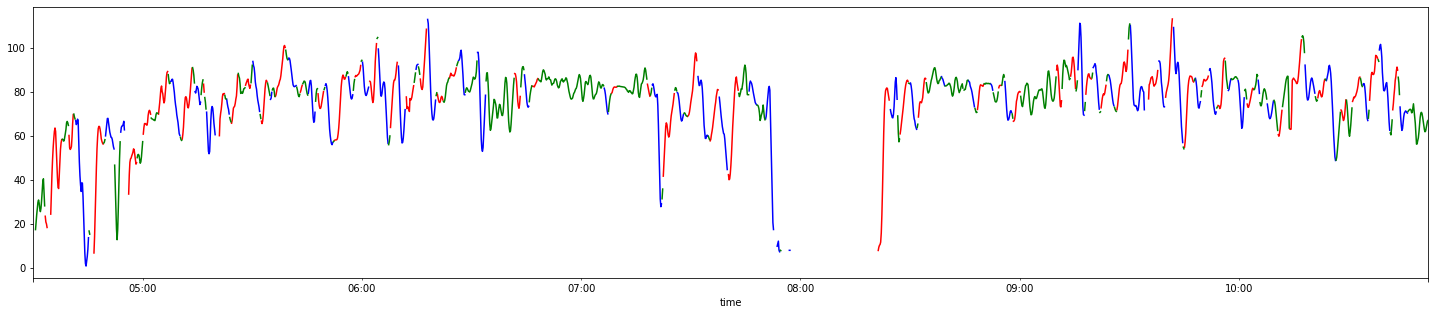

In [12]:
plot_trend(ts, TSSplineEstimator().predict(ts, k=0.5))

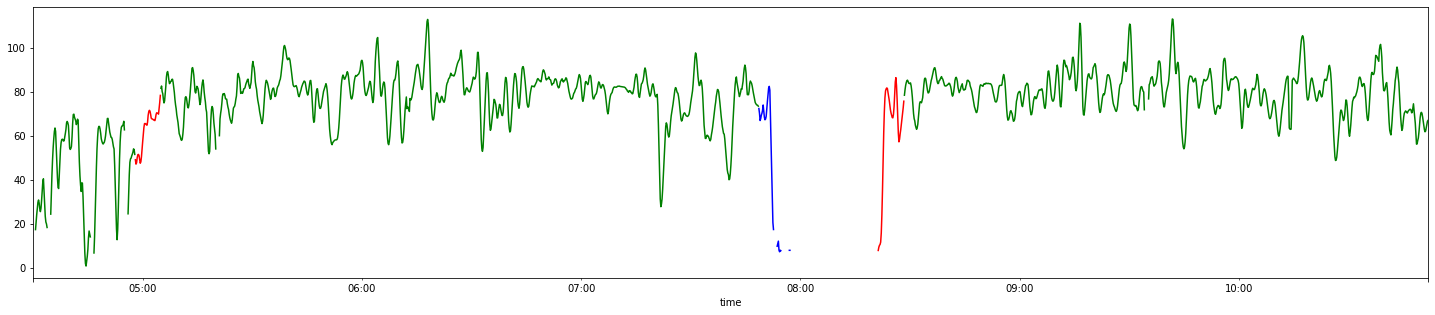

In [20]:
plot_trend(ts, TSSplineEstimator().predict(ts, k=0.11))

# SPLINE DEFECTS SCORING

In [35]:
from src.utils import spline_defect_trip_score, get_spline

def plot_ts_anomalies(score):
    plt.plot(score.index, score['score'].values, 'o', color='red')
    score['speed'].plot()
    plt.show()

In [42]:
get_spline(ts, 10).diff().min()

-0.00018627048461894447

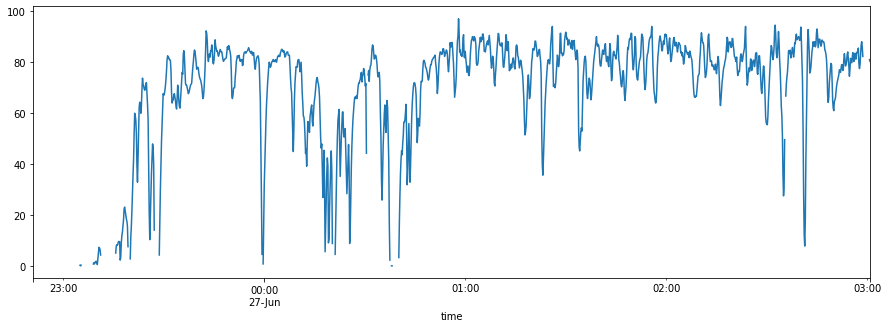

In [9]:
ts = df_resampled.loc['XTC549015J2510673'].tail(1_500)
ts.plot()

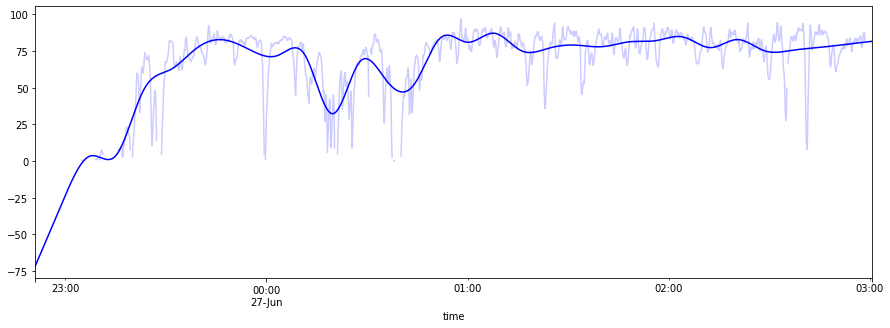

In [10]:
# start_time = pd.Timestamp('2020-07-27 05:30:40')
# start_time = np.random.choice(series.index)
# ts = series.loc[start_time : start_time + pd.Timedelta('1 hour')]

n_knots = 30
spline = get_spline(ts, n_knots)

plt.figure(figsize=(15,5))
spline.plot(color='blue')
ts.plot(color='blue', alpha=0.2)

plt.show()

In [33]:
ts = df_resampled.loc['XTC549015J2510673']

In [43]:
ts

time
2020-04-26 00:57:20          NaN
2020-04-26 00:57:30          NaN
2020-04-26 00:57:40          NaN
2020-04-26 00:57:50          NaN
2020-04-26 00:58:00          NaN
                         ...    
2020-06-27 03:00:10          NaN
2020-06-27 03:00:20    87.666667
2020-06-27 03:00:30          NaN
2020-06-27 03:00:40    81.000000
2020-06-27 03:00:50    80.250000
Name: speed, Length: 536422, dtype: float64

In [58]:
%time score = spline_defect_trip_score(ts, n_knots=15, method='score')


CPU times: user 8.87 s, sys: 212 ms, total: 9.08 s
Wall time: 8.79 s


In [163]:
from tqdm.notebook import tqdm_notebook as tqdm

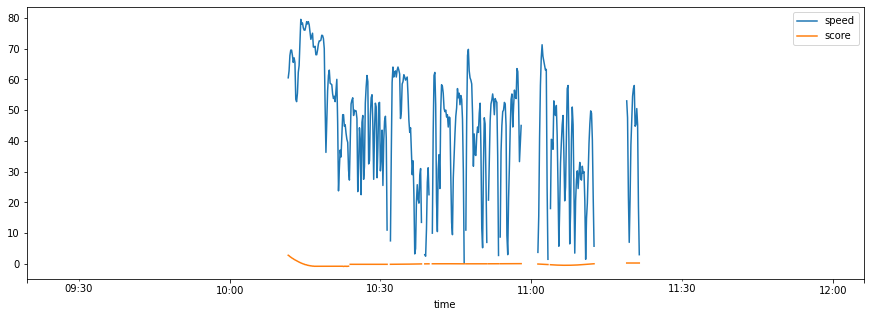

In [181]:
res[10].tail(1000).plot()

In [183]:
res = []
for car_vin, series in tqdm(df_resampled.groupby('car_vin')):
    series.index = series.index.droplevel('car_vin')
    score = spline_defect_trip_score(series, n_knots=8, method='diff', timedelta='1 hour')
    score['car_vin'] = car_vin
    res.append(score)
    
res = pd.concat(res)
res.set_index('car_vin', append=True, inplace=True)
res = res.reorder_levels(['car_vin', 'time']).sort_index()

In [257]:
from src.utils import spline_score_multiple_cars

In [201]:
result = spline_score_multiple_cars(df_resampled)

In [247]:
tmp = result.loc['XTC549015K2520928'].tail(1_000)

ts = tmp['speed']
score = tmp['score']

In [268]:
score

time
2020-07-01 15:46:20         NaN
2020-07-01 15:46:30         NaN
2020-07-01 15:46:40         NaN
2020-07-01 15:46:50         NaN
2020-07-01 15:47:00         NaN
                         ...   
2020-07-01 18:32:10   -0.490437
2020-07-01 18:32:20   -0.490437
2020-07-01 18:32:30   -0.490437
2020-07-01 18:32:40   -0.490437
2020-07-01 18:32:50         NaN
Name: score, Length: 1000, dtype: float64

In [260]:
from src.utils import score2cat

In [263]:
score2

time
2020-07-01 15:46:20         NaN
2020-07-01 15:46:30         NaN
2020-07-01 15:46:40         NaN
2020-07-01 15:46:50         NaN
2020-07-01 15:47:00         NaN
                         ...   
2020-07-01 18:32:10   -0.490437
2020-07-01 18:32:20   -0.490437
2020-07-01 18:32:30   -0.490437
2020-07-01 18:32:40   -0.490437
2020-07-01 18:32:50         NaN
Name: score, Length: 1000, dtype: float64

In [ ]:
s

In [276]:
tmp = score2cat(score)

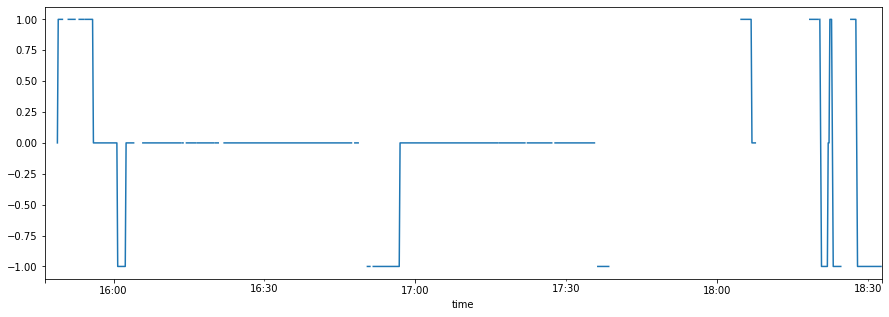

In [277]:
tmp.plot()

In [273]:
tmp.value_counts()

 0.0    523
-1.0    108
 1.0     66
Name: score, dtype: int64

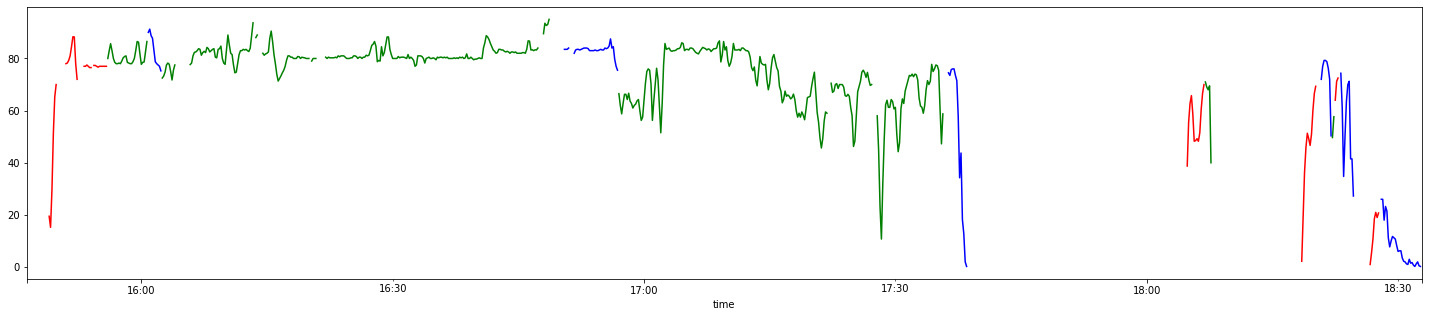

In [275]:
plot_trend(ts, score, 0.4, -0.15)

In [226]:
result.sample(10)

,,speed,score
car_vin,time,,
XTC549015K2520922,2020-05-12 17:29:50,NaN,NaN
XTC549015K2525477,2020-06-25 16:12:00,NaN,NaN
XTC549015J2519537,2020-05-10 15:59:10,NaN,NaN
XTC549015K2518880,2020-06-01 09:00:00,NaN,NaN
XTC549015L2532712,2020-06-19 12:55:50,NaN,NaN
XTC549015L2532261,2020-05-26 08:40:30,NaN,NaN
XTC549015K2525927,2020-06-06 07:31:00,NaN,NaN
XTC549015K2525436,2020-04-26 17:38:40,NaN,NaN
XTC549015K2525927,2020-04-29 02:39:30,NaN,NaN


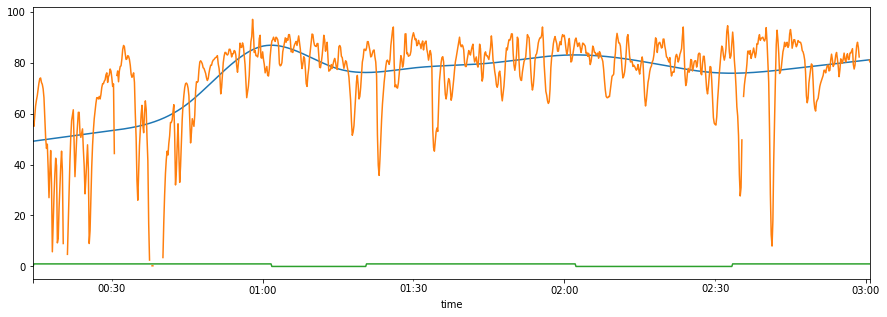

In [154]:
tmp = get_spline(ts.tail(1000), 10)
tmp.plot()
ts.tail(1000).plot()
(tmp.diff()>0).astype(int).plot()

In [157]:
score['score'].value_counts()

 0.0    102977
-1.0     30271
Name: score, dtype: int64

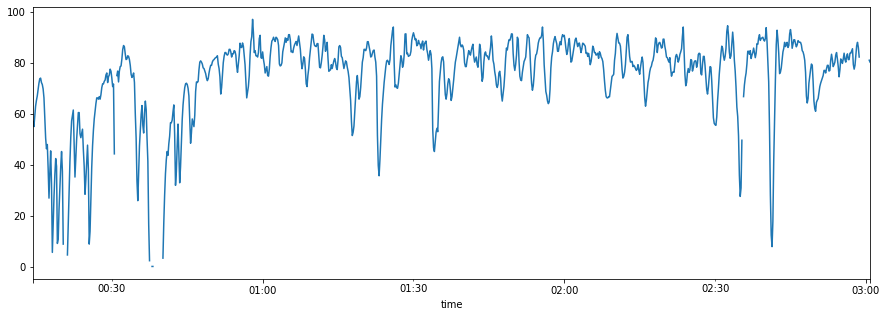

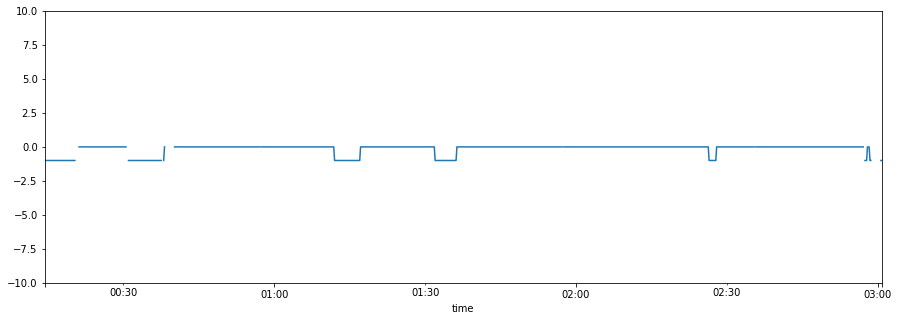

In [138]:
score['speed'].tail(1_000).plot()
plt.show()
(score['score'].tail(1_000)).plot()
plt.ylim(-10,10)
plt.show()

In [46]:
score['score'].dropna()

time
2020-04-26 06:37:00     4.50
2020-04-26 06:37:10    10.25
2020-04-26 06:37:20    22.00
2020-04-26 06:37:30    37.75
2020-04-26 06:37:40    54.50
                       ...  
2020-06-27 02:48:10    67.00
2020-06-27 02:48:20    64.25
2020-06-27 02:48:30    66.00
2020-06-27 02:48:40    72.00
2020-06-27 02:48:50    74.75
Name: score, Length: 28486, dtype: float64

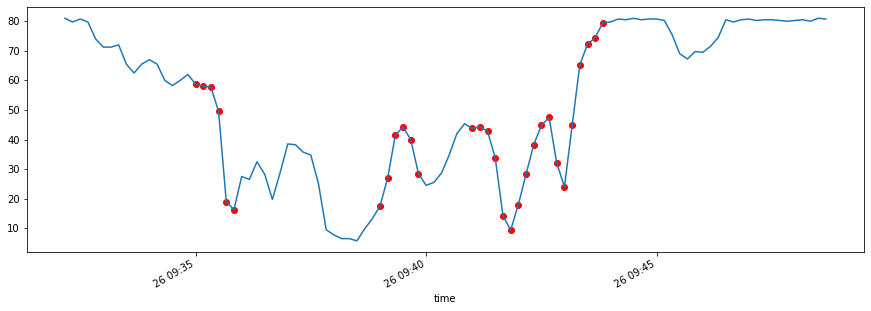

In [29]:
i = 1000
tmp = score[['score', 'speed']][~score['speed'].isna()].iloc[i:i+100]
plot_ts_anomalies(tmp)

XTC549015J2516693


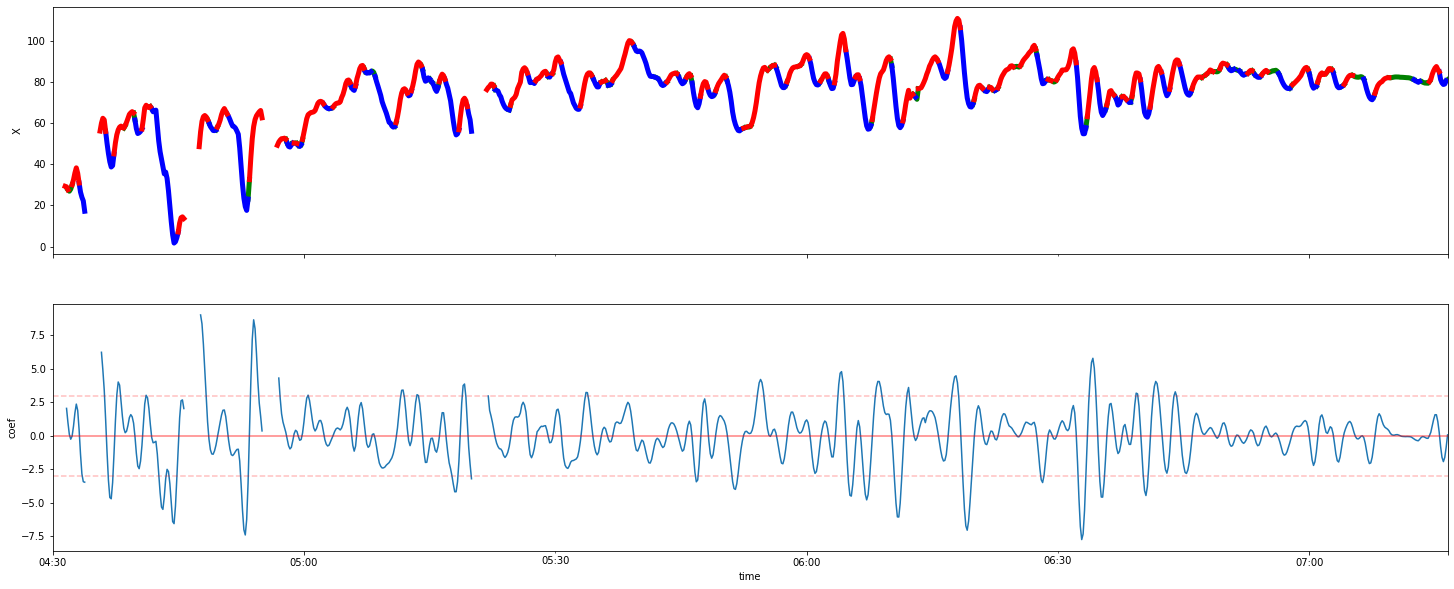

In [91]:
rand_vin = np.random.choice(vin_list)
print(rand_vin)
plot_TSTrendEstimation(res.loc[rand_vin].head(1_000), max_coef=3, min_coef=-3, n_lags=2)

# FFT

In [99]:
from scipy import fft

In [106]:
fft(df_resampled.values)

array([nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj])

# STASH

In [183]:
rand_vin = np.random.choice(vin_list)

In [184]:
df_orig = df.loc[rand_vin]
df_score = res.loc[rand_vin]
tmp = pd.merge_asof(df_orig, df_score, left_index=True, right_index=True)

XTC549015K2520656


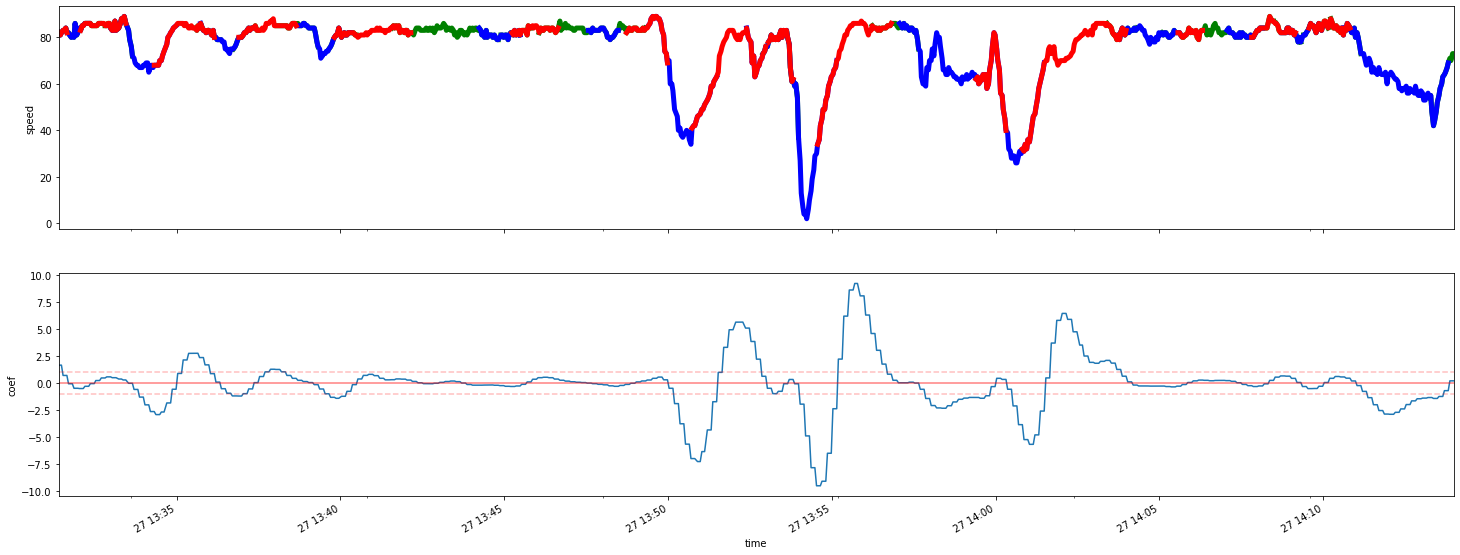

In [223]:
rand_vin = np.random.choice(vin_list)
print(rand_vin)
plot_TSTrendEstimation(tmp.head(5_000).tail(1_000), value='speed', max_coef=1, min_coef=-1, n_lags=6)